## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
from urllib.parse import urlparse
from scipy.stats import spearmanr

from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from tqdm import tqdm
from transformers import DistilBertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset3
from bert import CustomBert6
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from sentence_embed import get_use_embedding_features, get_distill_bert_features
from create_features import get_dist_features, get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from eda import eda
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

Using TensorFlow backend.


## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [13]:
num_aug = 4
train_aug_dfs = [train.copy() for _ in range(num_aug)]
test_aug_dfs = [test.copy() for _ in range(num_aug)]

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer.encode_plus(' \n \n \n ')

In [ ]:
%%time
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
ids_train = {}
ids_test = {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text in ['question', 'answer']:
        ids = (num_aug + 1) * []
        for x in tqdm(df[text].values):
            augs = eda(x, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=num_aug)
            encoded_inputs = []
            for i, aug in enumerate(augs):
                encoded_inputs = tokenizer.encode_plus(
                    x, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True)['input_ids']
                ids[i].append(encoded_inputs)
        if mode == 'train': ids_train[text] = [np.array(aug_ids) for aug_ids in ids]
        else: ids_test[text]  = [np.array(aug_ids) for aug_ids in ids]

In [6]:
eda(train['question_title'].values[0], alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=4)

['what am i losing when using tubes instead of a macro lens',
 'macro instruction what am i losing when using extension tubes instead of a macro lens',
 'what am i losing when using extension thermionic valve instead of a macro lens',
 'what am i losing when of extension tubes instead using a macro lens',
 'what am i losing when using extension tubes instead of a macro lens']

In [ ]:
train['question'] = train['question_title'] + ' [SEP] ' + train['question_body']
test['question'] = test['question_title'] + ' [SEP] ' + test['question_body']

In [4]:
init_seed()

In [5]:
%%time
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
ids_train = {}
ids_test = {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text in ['question', 'answer']:
        ids = []
        for x in tqdm(df[text].values):
            encoded_inputs = tokenizer.encode_plus(
                x, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True)
            ids.append(encoded_inputs['input_ids'])
        if mode == 'train': ids_train[text] = np.array(ids)
        else: ids_test[text] = np.array(ids)

100%|██████████| 476/476 [00:00<00:00, 491.44it/s]

CPU times: user 26.2 s, sys: 169 ms, total: 26.4 s
Wall time: 26.7 s


In [6]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [7]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)

cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
y = train[TARGETS].values.astype(np.float32)

In [9]:
num_workers = 10
bs = 4

In [10]:
bs_test = 4
test_loader = DataLoader(
    TextDataset3(cat_features_test, ids_test['question'], ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers
)

## Training model

In [11]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 6
grad_accum = 8
weight_decay = 0.01
model_name = 'distil_bert_2'
checkpoint_dir = 'checkpoints/'
early_stopping = None

In [12]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

lr_div = 100
def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.transformer, lr / lr_div, weight_decay)
        + get_optimizer_param_groups(model.q_transformer, lr / lr_div, weight_decay)
        + get_optimizer_param_groups(model.a_transformer, lr / lr_div, weight_decay)
        + get_optimizer_param_groups(model.q_emb, lr / lr_div, weight_decay)
        + get_optimizer_param_groups(model.a_emb, lr / lr_div, weight_decay)
    )

Fold 1 started at Tue Dec 24 21:51:48 2019
CustomBert6(
  (q_emb): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (a_emb): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (q_transformer): ModuleList(
    (0): TransformerBlock(
      (dropout): Dropout(p=0.1, inplace=False)
      (attention): MultiHeadSelfAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (q_lin): Linear(in_features=768, out_features=768, bias=True)
        (k_lin): Linear(in_features=768, out_features=768, bias=True)
        (v_lin): Linear(in_features=768, out_features=768, bias=True)
        (out_lin): Linear(in_features

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


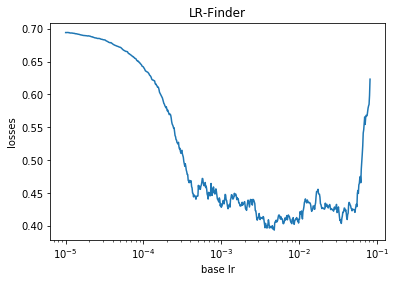

epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.47926 - spearmanr 0.090826
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.40256 - spearmanr 0.27068
best model: epoch 0 - 0.27068
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.39023 - spearmanr 0.29029
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.38194 - spearmanr 0.34782
best model: epoch 1 - 0.34782
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.37102 - spearmanr 0.36805
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.37338 - spearmanr 0.3826
best model: epoch 2 - 0.3826
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.36032 - spearmanr 0.40875
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.37046 - spearmanr 0.39273
best model: epoch 3 - 0.39273
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.35285 - spearmanr 0.43613
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.37054 - spearmanr 0.39433
best model: epoch 4 - 0.39433
epoch 5: 	 Start training...


KeyboardInterrupt: 

In [13]:
folds = KFold(n_splits=5, random_state=42)
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds.split(train)):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset3(cat_features_train, ids_train['question'], ids_train['answer'], train_index, y),
        batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True
    )
    valid_loader = DataLoader(
        TextDataset3(cat_features_train, ids_train['question'], ids_train['answer'], valid_index, y),
        batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True
    )
        
    model = CustomBert6(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=3)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / folds.n_splits
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#0.4003#0.4119

In [ ]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [ ]:
sample_submission.head()